In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from src.document_preprocessor import RegexTokenizer
from src.indexing import BasicInvertedIndex, Indexer, IndexType
from src.ranker import BM25, Ranker
from src.relevance import run_relevance_tests

from sentence_transformers import SentenceTransformer

In [2]:
STOPWORD_PATH = '../data/stopwords_updated.txt'
DATASET_PATH = '../data/processed_articles_dedup.csv'
INDEX_PATH = './output/index'

In [3]:
# Load in the stopwords
stopwords = set()
with open(STOPWORD_PATH, 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
f'Stopwords collected {len(stopwords)}'

'Stopwords collected 550'

In [4]:
preprocessor = RegexTokenizer("\w+(?:-\w+)*(?:'[^stmrvld]\w*)*", lowercase=True)

# index = Indexer.create_index(
#     index_type=IndexType.BasicInvertedIndex,
#     dataset_path=DATASET_PATH,
#     document_preprocessor=preprocessor,
#     stopwords=stopwords,
#     minimum_word_frequency=1,
#     text_key='body',
#     id_key='docid',
#     max_docs=35292
# )

# index.save(INDEX_PATH)

In [5]:
index = BasicInvertedIndex()
index.load(INDEX_PATH)

In [6]:
bm25_scorer = BM25(index)
bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)

In [7]:
metrics_bm25 = run_relevance_tests("../data/relevance_test.csv", ranker=bm25_ranker)

## BERT Interpolation on BM25

In [8]:
# Load the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

class HybridRanker:
    def __init__(self, base_ranker: Ranker, raw_text_dict: dict, alpha: float = 0.5, rerank_top_k: int = 10):
        self.base_ranker = base_ranker
        self.raw_text_dict = raw_text_dict
        self.alpha = alpha
        self.rerank_top_k = rerank_top_k
        self.model = model  # Use the loaded model

    def query(self, query: str) -> list[tuple[int, float]]:
        # Get initial BM25 rankings
        bm25_results = self.base_ranker.query(query)

        # Only rerank top k documents
        top_k_results = bm25_results[:self.rerank_top_k]

        # Get query embedding
        query_embedding = self.model.encode(query, normalize_embeddings=True)

        # Calculate BERT scores for top k
        reranked_scores = []
        docs = [self.raw_text_dict[docid] for docid, _ in top_k_results]
        doc_embeddings = self.model.encode(docs)

        # Calculate similarities
        for i, (docid, bm25_score) in enumerate(top_k_results):
            # Compute cosine similarity
            bert_score = float(doc_embeddings[i] @ query_embedding)

            # Combine scores using alpha
            final_score = self.alpha * bm25_score + (1 - self.alpha) * bert_score
            reranked_scores.append((docid, final_score))

        # Sort by combined score
        reranked_scores.sort(key=lambda x: x[1], reverse=True)

        return reranked_scores + bm25_results[self.rerank_top_k:]

# Load raw text for documents
raw_text_dict = {}
with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        raw_text_dict[int(row['docid'])] = row['body']

# Ablation study

- Dev set

In [10]:
dev_df = pd.read_csv("../data/relevance_dev.csv")
dev_df["query"].nunique()

13

In [26]:
# from src.BERT_ranker import HybridRanker

In [11]:
ablation_alpha = {}

In [12]:
for alpha in np.linspace(0, 1, 11):
    print(f"alpha: {alpha:.1f}", end=" ")
    
    # Create hybrid ranker
    hybrid_ranker = HybridRanker(
        # bi_encoder_model_name='sentence-transformers/all-MiniLM-L6-v2',
        base_ranker=bm25_ranker, 
        raw_text_dict=raw_text_dict,
        alpha=alpha, 
        rerank_top_k=10
    )
    
    # Run evaluation    
    metrics = run_relevance_tests("../data/relevance_dev.csv", ranker=hybrid_ranker)
    print(f"map: {metrics['map']:.4f}, ndcg: {metrics['ndcg']:.4f}")

    ablation_alpha[alpha] = metrics

alpha: 0.0 map: 0.2347, ndcg: 0.5753
alpha: 0.1 map: 0.2218, ndcg: 0.5652
alpha: 0.2 map: 0.2191, ndcg: 0.5718
alpha: 0.3 map: 0.2196, ndcg: 0.5728
alpha: 0.4 map: 0.2146, ndcg: 0.5667
alpha: 0.5 map: 0.2134, ndcg: 0.5654
alpha: 0.6 map: 0.2133, ndcg: 0.5690
alpha: 0.7 map: 0.2133, ndcg: 0.5699
alpha: 0.8 map: 0.2133, ndcg: 0.5703
alpha: 0.9 map: 0.2127, ndcg: 0.5696
alpha: 1.0 map: 0.2114, ndcg: 0.5674


In [13]:
with open('output/metrics_hybridranker_alphas_dev.json', 'w') as f:
    json.dump(ablation_alpha, f)

In [15]:
alphas = []
maps = []
ndcgs = []

for alpha, metrics in ablation_alpha.items():
    alphas.append(alpha)
    maps.append(metrics['map'])
    ndcgs.append(metrics['ndcg'])

len(alphas), len(maps), len(ndcgs)

(11, 11, 11)

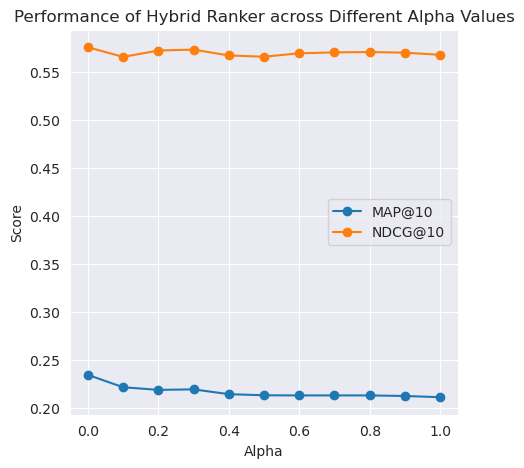

In [17]:
plt.figure(figsize=(5, 5))
plt.plot(alphas, maps, label='MAP@10', marker='o')
plt.plot(alphas, ndcgs, label='NDCG@10', marker='o')
plt.title('Performance of Hybrid Ranker across Different Alpha Values')
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend()
plt.show()

# Evaluation 

- Test set

In [ ]:
# Create hybrid ranker
hybrid_ranker = HybridRanker(
    base_ranker=bm25_ranker,
    raw_text_dict=raw_text_dict,
    alpha=0.3,
    rerank_top_k=10
)

# Run evaluation
metrics_hybrid = run_relevance_tests("../data/relevance_test.csv", ranker=hybrid_ranker)

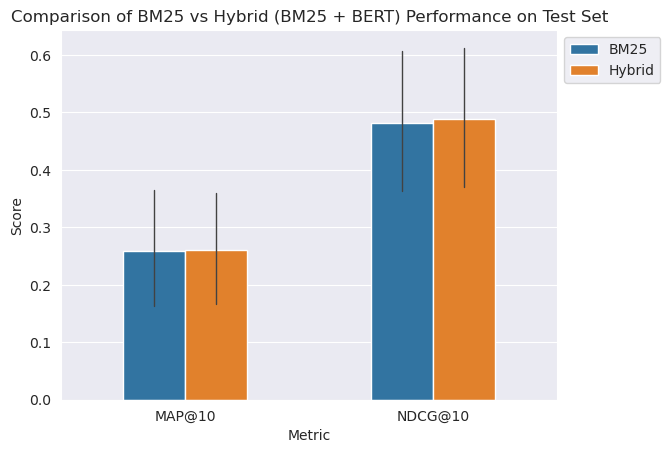

In [9]:
metrics = {
    "BM25": metrics_bm25,
    "Hybrid": metrics_hybrid,
}

metrics_df = []
for ranker, metrics in metrics.items():
    metrics_df.append({
        "ranker": ranker, "metric": "MAP@10", 
        "mean_score": metrics["map"], "scores": metrics["map_list"]
    })
    metrics_df.append({
        "ranker": ranker, "metric": "NDCG@10", 
        "mean_score": metrics["ndcg"], "scores": metrics["ndcg_list"]
    })
    
metrics_df = pd.DataFrame(metrics_df)
metrics_df_long = metrics_df.drop("mean_score", axis=1).explode("scores")

sns.barplot(data=metrics_df_long, x="metric", y="scores", hue="ranker", 
            estimator='mean', errorbar=('ci', 95), width=0.5, errwidth=1)

plt.title("Comparison of BM25 vs Hybrid (BM25 + BERT) Performance on Test Set")
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Metric")
plt.ylabel("Score")
plt.show()